### Data Processing

In [67]:
import sys
print("Python version")
print (sys.version)

Python version
3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]


In [68]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry
import seaborn as sns
import sqlite3

In [69]:
# Reading our data
df = pd.read_csv('../data/Data.csv')

In [70]:
# Let's have a peek at our dataset!
df.head()

Entity Continent  Latitude  Longitude  Average temperature per year  \
0  Albania    Europe     41.15      20.17                            14   
1  Albania    Europe     41.15      20.17                            14   
2  Albania    Europe     41.15      20.17                            14   
3  Albania    Europe     41.15      20.17                            14   
4  Albania    Europe     41.15      20.17                            14   

   Hospital beds per 1000 people  Medical doctors per 1000 people  GDP/Capita  \
0                           2.89                             1.29      5353.2   
1                           2.89                             1.29      5353.2   
2                           2.89                             1.29      5353.2   
3                           2.89                             1.29      5353.2   
4                           2.89                             1.29      5353.2   

   Population  Median age  Population aged 65 and over (%)        Date  \
0     2873457          38                               14  2020-02-25   
1     2873457          38                               14  2020-02-26   
2     2873457          38                               14  2020-02-27   
3     2873457          38                               14  2020-02-28   
4     2873457          38                               14  2020-02-29   

   Daily tests  Cases  Deaths  
0          8.0    NaN     NaN  
1          5.0    NaN     NaN  
2          4.0    NaN     NaN  
3          1.0    NaN     NaN  
4          8.0    NaN     NaN

In [71]:
df = df.convert_dtypes()

In [72]:
#We have 14 features and 38472 observations.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38472 entries, 0 to 38471
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Entity                           38472 non-null  string 
 1   Continent                        38472 non-null  string 
 2   Latitude                         38472 non-null  Float64
 3   Longitude                        38472 non-null  Float64
 4   Average temperature per year     38472 non-null  Int64  
 5   Hospital beds per 1000 people    38472 non-null  Float64
 6   Medical doctors per 1000 people  38472 non-null  Float64
 7   GDP/Capita                       38472 non-null  Float64
 8   Population                       38472 non-null  Int64  
 9   Median age                       38472 non-null  Int64  
 10  Population aged 65 and over (%)  38472 non-null  Int64  
 11  Date                             38472 non-null  string 
 12  Daily tests       

In [73]:
#There are no duplicated rows
df.duplicated().sum()

0

In [74]:
#Entity is the country name and there doesn't seem to be misspelt countries based on eye test. However, let's use pycountry to check!
df['Entity'].sort_values().unique()

<StringArray>
[             'Albania',              'Algeria',            'Argentina',
              'Armenia',            'Australia',              'Austria',
              'Bahrain',           'Bangladesh',              'Belarus',
              'Belgium',
 ...
               'Turkey',               'Uganda',              'Ukraine',
 'United Arab Emirates',       'United Kingdom',        'United States',
              'Uruguay',              'Vietnam',               'Zambia',
             'Zimbabwe']
Length: 104, dtype: string

In [75]:
df.columns

Index(['Entity', 'Continent', 'Latitude', 'Longitude',
       'Average temperature per year', 'Hospital beds per 1000 people',
       'Medical doctors per 1000 people', 'GDP/Capita', 'Population',
       'Median age', 'Population aged 65 and over (%)', 'Date', 'Daily tests',
       'Cases', 'Deaths'],
      dtype='object')

In [76]:
# We have 3 features with missing values in ascending order, daily tests of COVID-19, deaths from COVID-19, and daily cases of COVID-19
df.isna().sum().sort_values(ascending=False)

Daily tests                        7895
Deaths                             3610
Cases                               254
Entity                                0
Continent                             0
Latitude                              0
Longitude                             0
Average temperature per year          0
Hospital beds per 1000 people         0
Medical doctors per 1000 people       0
GDP/Capita                            0
Population                            0
Median age                            0
Population aged 65 and over (%)       0
Date                                  0
dtype: int64

In [77]:
# Our missing data is in the form of NaNs. The features are daily tests, cases and deaths.
# As the data is time sensitive, we can't just fill the missing values with the mean or median of the feature.
# We can group the data by countries, then forward fill the missing values with the previous day's value if it is missing. (Last Observation Carried Forward)
# This is because the cases and deaths are cumulative.
# We can then fill the remaining missing values with the next day's value for the other missing values. (Next Observation Carried Backward)
df = df.groupby('Entity').apply(lambda x: x.fillna(method='ffill'))
df = df.groupby('Entity').apply(lambda x: x.fillna(method='bfill'))

In [78]:
def checkCountryNames(listOfCountries):
    """
    -------------------------------------------------------------------------------
    This function takes a list of countries and returns a list of countries.
    -------------------------------------------------------------------------------
    Input:
    listOfCountries: list of countries
    -------------------------------------------------------------------------------
    Output:
    listOfCountries: list of countries
    -------------------------------------------------------------------------------
    """
    count = 0
    missing_countries = []
    for country in listOfCountries:
        try:
            pycountry.countries.get(name=country)
        except:
            print(f'{country} not found!')
            count+=1
            missing_countries.append(country)
    print(f'Total number of countries not found: {count}')
    return missing_countries

In [79]:
def getIsoAlphaCode(listOfCountries):
    """
    -------------------------------------------------------------------------------
    This function takes a list of countries and returns a list of countries or 
    a list of missing countries if the country is not found.
    -------------------------------------------------------------------------------
    Input:
    listOfCountries: list of countries to search
    -------------------------------------------------------------------------------
    Output:
    missing_countries: list of names of that are not found
    list_of_codes : list of ISO Alpha 3 codes for found countries
    -------------------------------------------------------------------------------
    """
    count = 0
    list_of_codes = []
    missing_countries = []
    for country in listOfCountries:
        try:
            code = pycountry.countries.search_fuzzy(country)[0].alpha_3
            list_of_codes.append(code)
        except:
            print(f'{country} not found!')
            code = np.NaN
            count+=1
            missing_countries.append(country)
    print(f'Total number of countries not found: {count}')
    if count>0:
        print('Missing Countries returned.')
        return missing_countries
    else:
        print('List of codes for countries returned.')
        return list_of_codes

In [80]:
# Excellent! No misspelt countries!
missing_countries = checkCountryNames(df['Entity'].unique())

Total number of countries not found: 0


In [81]:
# I have an idea for my visualization. Let's get the ISO Alpha 3 codes for each country.
# We need to change the name of the country, Cape Verde to Capo Verde.
results = getIsoAlphaCode(df['Entity'].unique())

Cape Verde not found!
Total number of countries not found: 1
Missing Countries returned.


In [82]:
df.loc[df['Entity']==results[0],'Entity'] = 'Cabo Verde'

In [83]:
results = getIsoAlphaCode(df['Entity'].unique())

Total number of countries not found: 0
List of codes for countries returned.


In [84]:
df['Iso Alpha Code'] = df['Entity'].map(dict(zip(df['Entity'].unique(),results)))

In [85]:
#There are 7 continents in the world, our dataset has 6. It excludes Antarctica :)
print(df['Continent'].nunique())
print(df['Continent'].unique())

6
<StringArray>
['Europe', 'Africa', 'South America', 'Oceania', 'Asia', 'North America']
Length: 6, dtype: string


In [86]:
#We can use factorize get the numeric representation of an array, and therefore get a unique number to identify each country.
df['ID'] = pd.factorize(df['Entity'])[0]

In [87]:
#Great!
df[['Entity','ID']].drop_duplicates()

Entity   ID
0            Albania    0
370          Algeria    1
740        Argentina    2
1144         Armenia    3
1509       Australia    4
...              ...  ...
36618  United States   99
37022        Uruguay  100
37375        Vietnam  101
37778         Zambia  102
38126       Zimbabwe  103

[104 rows x 2 columns]

### Data Exploration and Visualization

<AxesSubplot:>

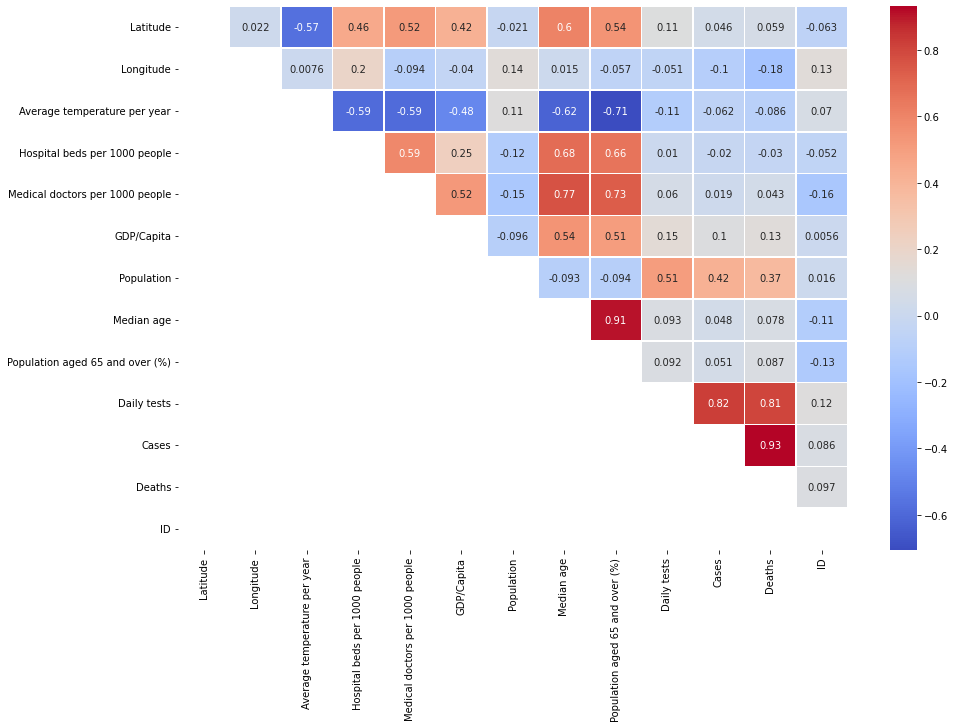

In [88]:
# Correlation matrix
# The number of daily tests , cases and deaths are highly correlated with each other.
# Population is slightly positively correlated with higher daily tests, cases and deaths.
# Hospital beds per 1000 people is positively correlated with medical doctors per 1000 people. Resource availability and infrastructure is probably important in facing pandemics.
#  I would like to view visualizations of some of these features.
# If I were to create a linear model, I would have to drop some features that are highly correlated with each other,
# I would have to pick median age or ppl aged 65+ as they are highly correlated with each other.
# I would have to pick hospital beds per 1000 people or medical doctors per 1000 people as they are highly correlated with each other.
# I would have to pick deaths or cases as they are highly correlated with each other.
plt.figure(figsize=(15,10))
mask = np.tril(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',linewidths=0.5, mask=mask)

In [89]:
df.columns

Index(['Entity', 'Continent', 'Latitude', 'Longitude',
       'Average temperature per year', 'Hospital beds per 1000 people',
       'Medical doctors per 1000 people', 'GDP/Capita', 'Population',
       'Median age', 'Population aged 65 and over (%)', 'Date', 'Daily tests',
       'Cases', 'Deaths', 'Iso Alpha Code', 'ID'],
      dtype='object')

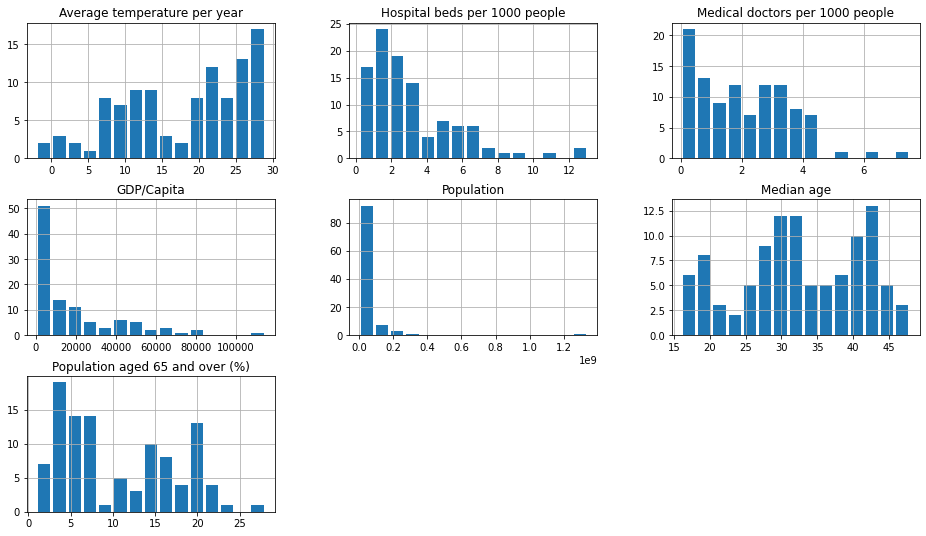

In [90]:

columns = ['Date', 'Daily tests', 'Cases', 'Deaths']
df[['Average temperature per year', 'Hospital beds per 1000 people',
       'Medical doctors per 1000 people', 'GDP/Capita', 'Population',
       'Median age', 'Population aged 65 and over (%)']].drop_duplicates().hist(bins=15, figsize=(16, 9), rwidth=0.8)
plt.show()


In [91]:
static_variables = df[['Average temperature per year', 'Hospital beds per 1000 people',
       'Medical doctors per 1000 people', 'GDP/Capita', 'Population',
       'Median age', 'Population aged 65 and over (%)']].drop_duplicates()

In [92]:
static_variables.skew()

Average temperature per year      -0.466152
Hospital beds per 1000 people      1.609410
Medical doctors per 1000 people    0.656351
GDP/Capita                         1.808136
Population                         8.064372
Median age                        -0.181404
Population aged 65 and over (%)    0.396037
dtype: float64

In [93]:
static_variables.kurtosis()

Average temperature per year       -0.887300
Hospital beds per 1000 people       3.022327
Medical doctors per 1000 people     0.386749
GDP/Capita                          3.371672
Population                         73.678999
Median age                         -1.064499
Population aged 65 and over (%)    -1.125943
dtype: float64

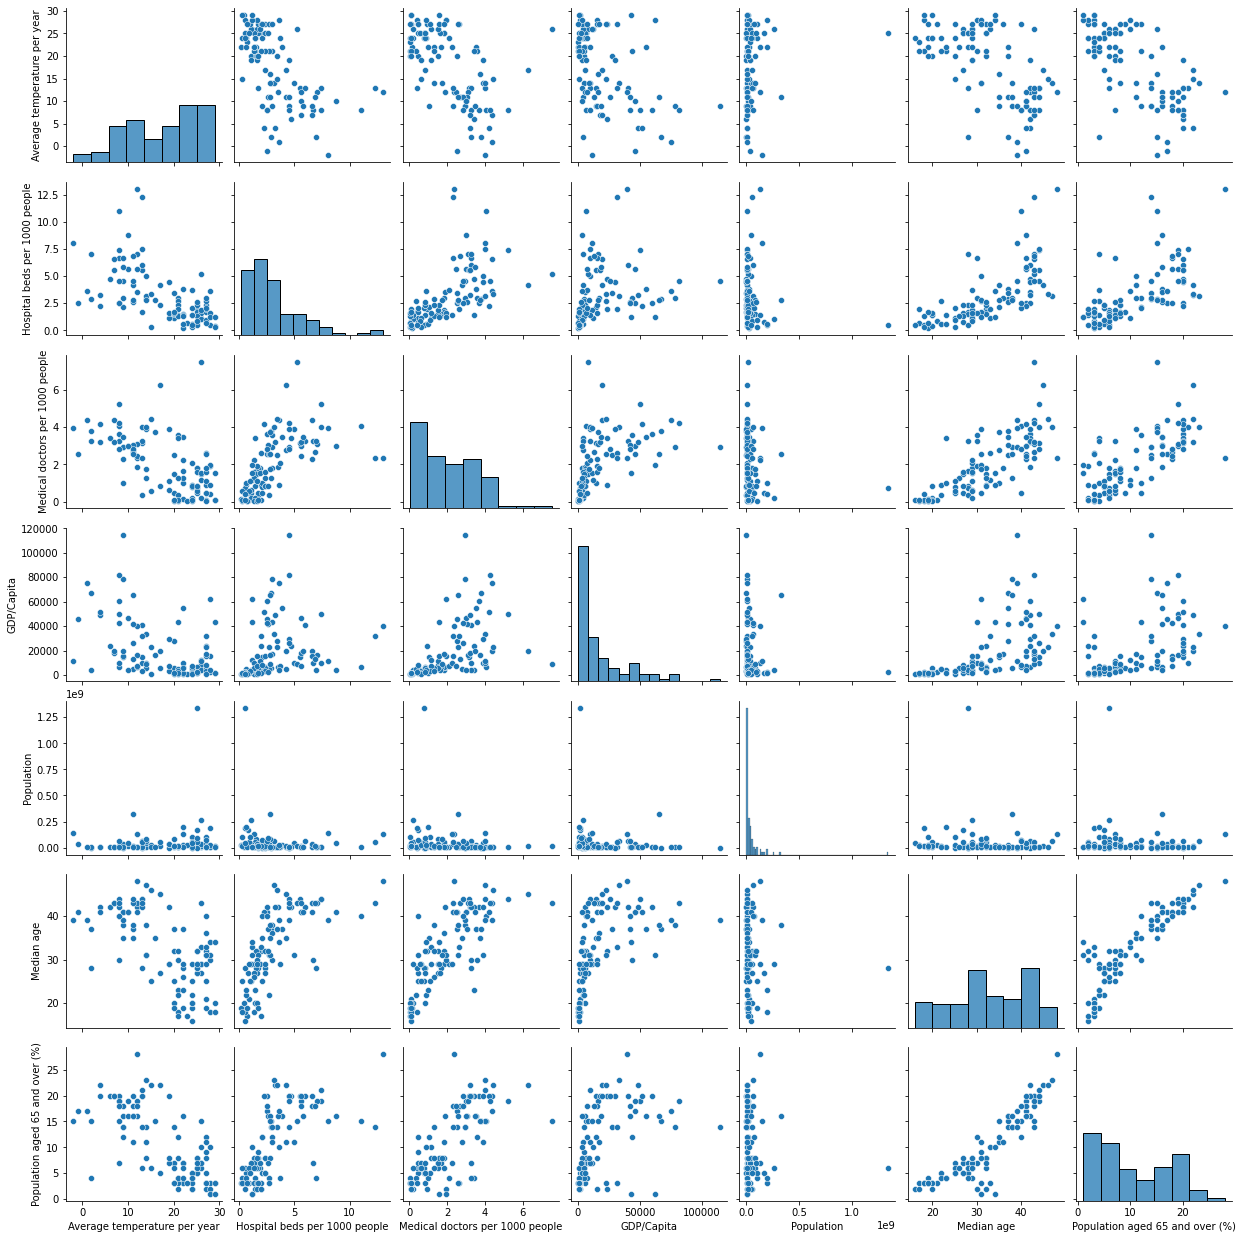

In [94]:
sns.pairplot(static_variables)

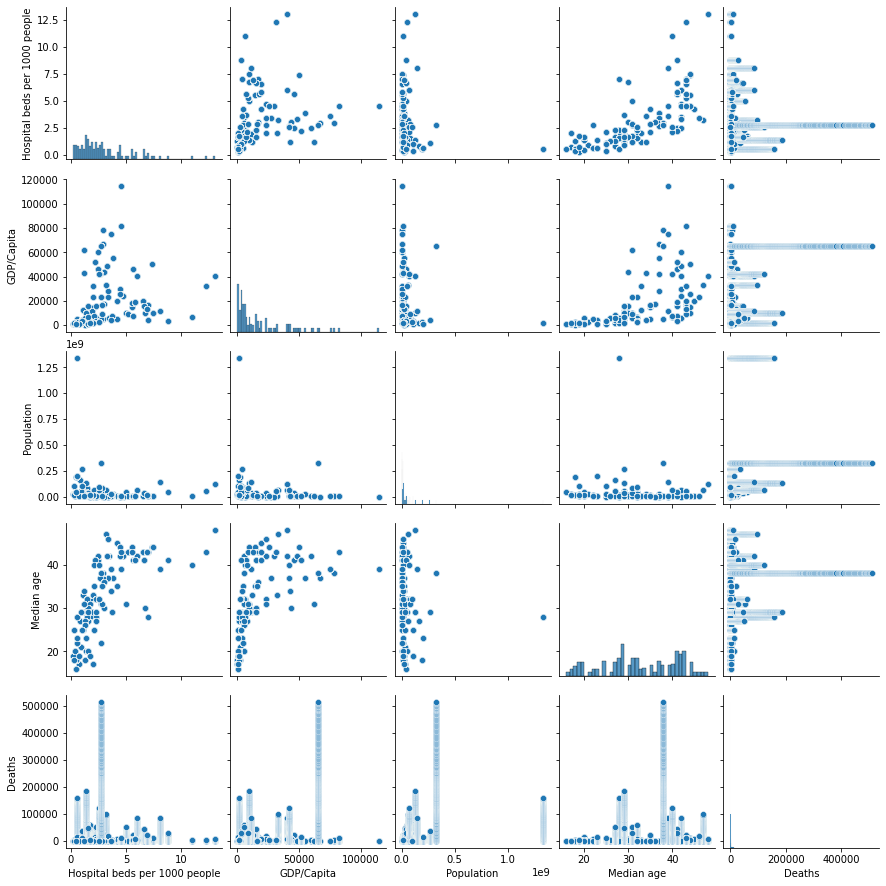

In [95]:
sns.pairplot(df, vars=['Hospital beds per 1000 people', 'GDP/Capita', 'Population',
       'Median age', 'Deaths'])

### Export to SQLite3

In [96]:
#Rearranging ID to be at the front of the dataframe.
df = df[['ID', 'Iso Alpha Code','Entity', 'Continent', 'Latitude', 'Longitude',
       'Average temperature per year', 'Hospital beds per 1000 people',
       'Medical doctors per 1000 people', 'GDP/Capita', 'Population',
       'Median age', 'Population aged 65 and over (%)', 'Date', 'Daily tests',
       'Cases', 'Deaths']]

In [97]:
df.dtypes

ID                                   int64
Iso Alpha Code                      object
Entity                              string
Continent                           string
Latitude                           Float64
Longitude                          Float64
Average temperature per year         Int64
Hospital beds per 1000 people      Float64
Medical doctors per 1000 people    Float64
GDP/Capita                         Float64
Population                           Int64
Median age                           Int64
Population aged 65 and over (%)      Int64
Date                                string
Daily tests                          Int64
Cases                                Int64
Deaths                               Int64
dtype: object

In [98]:
entity_info = df.drop(columns=['Daily tests','Cases','Deaths','Date']).drop_duplicates().reset_index(drop=True)
entity_info.head()

ID Iso Alpha Code     Entity      Continent  Latitude  Longitude  \
0   0            ALB    Albania         Europe     41.15      20.17   
1   1            DZA    Algeria         Africa     28.03       1.66   
2   2            ARG  Argentina  South America    -38.42     -63.62   
3   3            ARM    Armenia         Europe     40.07      45.04   
4   4            AUS  Australia        Oceania    -25.27     133.78   

   Average temperature per year  Hospital beds per 1000 people  \
0                            14                           2.89   
1                            25                            1.9   
2                            14                            5.0   
3                            11                            4.2   
4                            22                           3.84   

   Medical doctors per 1000 people  GDP/Capita  Population  Median age  \
0                             1.29      5353.2     2873457          38   
1                             1.83      3974.0    41318142          29   
2                             3.91      9912.3    44271041          31   
3                              2.8      4622.7     2930450          35   
4                              3.5     55060.3    24598933          37   

   Population aged 65 and over (%)  
0                               14  
1                                6  
2                               11  
3                               11  
4                               16

In [99]:
case_info = df[['Entity','Date','Daily tests','Cases','Deaths']].reset_index().rename(columns={'index':'Case ID'})
case_info.head()

Case ID   Entity        Date  Daily tests  Cases  Deaths
0        0  Albania  2020-02-25            8      2       1
1        1  Albania  2020-02-26            5      2       1
2        2  Albania  2020-02-27            4      2       1
3        3  Albania  2020-02-28            1      2       1
4        4  Albania  2020-02-29            8      2       1

In [100]:
con = sqlite3.connect("../data/database.db")
cur = con.cursor()

In [101]:
cur.execute('DROP TABLE IF EXISTS Entity')
cur.execute('DROP TABLE IF EXISTS Covid_Records')

In [102]:
cur.executescript("""
CREATE TABLE IF NOT EXISTS Entity(id INTEGER PRIMARY KEY NOT NULL, 
iso_alpha_code TEXT NOT NULL,
entity TEXT NOT NULL, continent TEXT NOT NULL, latitude REAL NOT NULL, 
longitude REAL NOT NULL, average_annual_temperature INTEGER NOT NULL, 
hospital_beds_per_1000_people REAL NOT NULL,
doctors_per_1000_people REAL NOT NULL,
gdp_per_capita REAL NOT NULL,
population INTEGER NOT NULL,
median_age INTEGER NOT NULL,
aged_65_older_percentage INTEGER NOT NULL);

CREATE TABLE IF NOT EXISTS Covid_Records(
id INTEGER PRIMARY KEY NOT NULL,
entity TEXT NOT NULL,
date TEXT NOT NULL,
daily_tests INTEGER NOT NULL,
cases INTEGER NOT NULL,
deaths INTEGER NOT NULL)
""")


In [103]:
cur.executemany("""
INSERT INTO Entity VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?)""",
entity_info.values)


cur.executemany("""
INSERT INTO Covid_Records VALUES(?,?,?,?,?,?)""",
case_info.values)

con.commit()

### Visualizations via SQL Statements


#### Visualization 1:
##### Having an ageing population with an increasing median age or higher % of people aged 65 and over,is correlated with access to hospital beds and doctors for treatment. As countries with aging populations typically have declining fertility rates, higher life expectancy, and higher GDP, they can afford to invest in healthcare. The poorer countries with younger populations have less access to hospital beds and doctors.


In [104]:
retrieval = cur.execute('''SELECT 
entity,
continent,
hospital_beds_per_1000_people,
doctors_per_1000_people,
gdp_per_capita,
median_age
FROM Entity''')

info_1 = pd.DataFrame(retrieval.fetchall(),columns= ['Entity', 'Continent','Hospital beds/1000 people','Medical doctors/1000 people',
       'GDP/Capita','Median age'])


In [105]:
visual_1 = px.scatter(info_1, x='Median age', y='Hospital beds/1000 people', color='Continent', title='Access to hospital beds by country', size='GDP/Capita', hover_name='Entity',size_max=30)
visual_1.update_traces(    marker=dict(sizemin=2))
visual_1.show()
visual_1.write_html("..//output/Visualization 1.html")

In [106]:
px.scatter(info_1, x='Median age', y='Medical doctors/1000 people', color='Continent', title='Access to medical doctors by country', size='GDP/Capita', hover_name='Entity',size_max=30).update_traces(    marker=dict(sizemin=2)).show()


#### Visualization 2: 
##### Average temperature impact on the transmissibility of COVID-19 is not conclusive. Monthly average temperature of a country may be more informative than the annual average temperature. Based on our data, average temperature does not contribute to the spread of the virus. If so, there would be a clearer separation between the yellow and purple scatterplots. I wish I had data on attitudes towards trust on government , covid regulations and apathy as they may be reasons for our outliers. However, our dataset doesn't have this information.

In [107]:
case_info

Case ID    Entity        Date  Daily tests  Cases  Deaths
0            0   Albania  2020-02-25            8      2       1
1            1   Albania  2020-02-26            5      2       1
2            2   Albania  2020-02-27            4      2       1
3            3   Albania  2020-02-28            1      2       1
4            4   Albania  2020-02-29            8      2       1
...        ...       ...         ...          ...    ...     ...
38467    38467  Zimbabwe  2021-02-24         1804  35960    1456
38468    38468  Zimbabwe  2021-02-25         2965  35994    1458
38469    38469  Zimbabwe  2021-02-26         2965  36044    1463
38470    38470  Zimbabwe  2021-02-27         2965  36058    1463
38471    38471  Zimbabwe  2021-02-28         2965  36089    1463

[38472 rows x 6 columns]

In [108]:
retrieval = cur.execute('''SELECT 
entity,average_annual_temperature,population,
date,
daily_tests,
cases,
deaths
FROM Covid_Records
INNER JOIN Entity 
USING(entity)
''')


info_2 = pd.DataFrame(retrieval.fetchall(),columns=[ 'Entity', 'Average temperature per year','Population','Date','Daily tests','Cases','Deaths'])

In [109]:
info_2['Cases per 100,000 people'] = info_2['Cases']/info_2['Population']*100000

In [110]:
info_2['Date'] = pd.to_datetime(info_2['Date'])

In [111]:
# When we look at this visualization, we can see that USA and India had the most cases. 
# How could they be the only ones to mess it up so badly? 
# It seems unlikely that the rest of the world had no problems with the virus.
px.scatter(info_2, x='Date', y='Cases', color='Average temperature per year', title='Covid-19 Cases by Country', hover_name='Entity')

In [112]:
#Using cases per 100,000 people instead of cases, we can see that the USA and India are not the only ones with a lot of cases.
# We can also see that temperature has nosstrong effect on the number of cases as there would be a clear separation of lines between the different temperatures.
# Temperature can vary throughout the year, so the data is not useful in showing the effects of the virus on transmissibility.
visual_2 = px.scatter(info_2, x='Date', y='Cases per 100,000 people', color='Average temperature per year', title='Covid-19 Cases per 100,000 people by Country', hover_name='Entity')
visual_2.show()
visual_2.write_html("..//output/Visualization 2.html")

#### Visualization 3: 
#### A month's end animated visualization of Covid Deaths by country in the form of a choropleth.

In [114]:
retrieval = cur.execute('''SELECT iso_alpha_code,entity,population,average_annual_temperature,
date,
daily_tests,
cases,
deaths
FROM Covid_Records
INNER JOIN Entity 
USING(entity)
''')


info_3 = pd.DataFrame(retrieval.fetchall(),columns=[ 'Iso Alpha Code','Entity', 'Population','Average temperature per year','Date','Daily tests','Cases','Deaths'])

In [115]:
info_3['Animation'] = info_3['Date'].apply(lambda x:  x[:-3])

In [116]:
info_3 = info_3.groupby(['Entity','Animation']).last().reset_index().sort_values('Date')

In [117]:
# It seems more fair to display the number of cases per 100,000 people, rather than the raw number of deaths.
info_3['Deaths/100,000 people'] = info_3['Deaths']/info_3['Population']*100000

In [119]:
import plotly.express as px

visual_3 = px.choropleth(info_3, locations="Iso Alpha Code",
                    color="Deaths/100,000 people", animation_group='Animation',
                    hover_name="Entity",hover_data=['Population','Cases','Deaths','Deaths/100,000 people'], animation_frame="Animation",title='Covid-19 Deaths per 100,000 people by Country',range_color=[0,200],color_continuous_scale=px.colors.sequential.Plasma)  
visual_3.update_layout(
        autosize=False,
        margin = dict(l=60, r=60, t=50, b=50,
                pad=0,
                autoexpand=True,
            ),
            width=1000,
             height=500,
             
    )
visual_3.write_html("..//output/Visualization 3.html")

In [120]:
visual_3

## Thank you for the opportunity!
## - Ashwin